In [1]:
# libraries

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from ta.volatility import BollingerBands
from ta.momentum import StochRSIIndicator,StochasticOscillator,ROCIndicator,TSIIndicator
from ta.trend import KSTIndicator, SMAIndicator
import warnings
warnings.filterwarnings("ignore")

In [24]:
class BacktestBase(object):
    
    def __init__(self, symbol,start,end,amount,ftc=0.0, ptc= 0.0, verbose=True):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.initial_amount = amount
        self.amount = amount
        self.ftc = ftc
        self.ptc = ptc
        self.units = 0
        self.position = 0
        self.trades = 0
        self.trades = 0
        self.verbose = verbose
        self.data = None
        self.raw_data = None
        self.get_data()
        self.signal_price()
        self.sell_price = None


    def get_data(self):

        df = yf.download(self.symbol, start=self.start, end=self.end)

        self.raw_data = df.copy()

        indicator_kst = KSTIndicator(close = df.Close)
        df["KST"] = indicator_kst.kst()

        indicator_tsi = TSIIndicator(df.Close)
        df["TSI"] = indicator_tsi.tsi()
        
        indicator_bb90 = BollingerBands(close = df.Close,window=90)
        df['pb90'] = indicator_bb90.bollinger_pband()*100
        df['Upper'] = indicator_bb90.bollinger_hband()
        df['Lower'] = indicator_bb90.bollinger_lband()

        indicator_200sma = SMAIndicator(close= df.Close, window=200)
        df["200SMA"] = indicator_200sma.sma_indicator()
    
        indicator_60sma = SMAIndicator(close=df.Close, window=60)
        df["60SMA"] = indicator_60sma.sma_indicator()

        indicator_so = StochasticOscillator(df.High, df.Low, df.Close)
        df["sOsc"] = indicator_so.stoch()

        indicator_roc = ROCIndicator(df.Close,window=1)
        df["ROC"] = indicator_roc.roc()

        indicator_srsi = StochRSIIndicator(close= df.Close, window= 14, smooth1= 3, smooth2= 3, fillna= False)
        df["SRSI"]= indicator_srsi.stochrsi() *100

        self.data = df.dropna()

    def get_date_price(self,bar):

        date = str(self.data.Close.index[bar])[:10]
        price = self.data.Close.iloc[bar]
        return date, price
    
    def print_balance(self, bar):

        date, price = self.get_date_price(bar)
        print(f'{date}| current balance {self.amount:.2f}')

    def print_net_wealth(self,bar):

        date, price = self.get_date_price(bar)
        net_wealth = self.units * price + self.amount
        print(f'{date}| current net wealth {net_wealth:.2f}')

    def place_buy_order(self, bar, units=None, amount=None, price=None):

        if price is None:
            date,price = self.get_date_price(bar)
        else:
            date = self.get_date_price(bar)

        if units is None:
            units = int(amount/price)

        self.amount -= (units*price) * (1 + self.ptc) + self.ftc
        self.units += units
        self.trades += 1

        if self.verbose:
            print(f'{date} | buying {units} units at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)

    def place_sell_order(self, bar, units=None, amount=None, price = None):

        if price is None:
            date,price = self.get_date_price(bar)
        else:
            date = self.get_date_price(bar)

        if units is None:
            units = int(amount/price)

        self.amount += (units*price) * (1 - self.ptc) - self.ftc
        self.units -= units
        self.trades += 1

        if self.verbose:
            print(f'{date} | selling {units} units at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)

    def close_out(self, bar):

        date, price = self.get_date_price(bar)
        self.amount += self.units * price
        self.units = 0
        self.trades += 1

        if self.verbose:
            print(f'{date} | inventory {self.units} units at {price:.2f}')
            print("="*55)
            print('Final balance [$] {:.2f}'.format(self.amount))
            perf = ((self.amount - self.initial_amount) / self.initial_amount * 100)
            print('Net performance [%] {:.2f}'.format(perf))
            print("Number of transaction executed [#] {:.2f}".format(self.trades))
    def signal_price(self):
        def calculate_indicators(data):
            df = data[['Close','Open']].copy()

            indicator_kst = KSTIndicator(close = df.Close)
            df["KST"] = indicator_kst.kst()

            indicator_tsi = TSIIndicator(df.Close)
            df["TSI"] = indicator_tsi.tsi()
            
            indicator_bb90 = BollingerBands(close = df.Close,window=90)
            df['pb90'] = indicator_bb90.bollinger_pband()*100

            df['buy_signal'] = 0
            #print("indicators calculated succesfully")
            return df
        
        def get_signal(data):
            if data["TSI"].iloc[-1] < -25 and data["pb90"].iloc[-1] < -5:
                return data["Close"].iloc[-1]
            return -1

        def manu_last_row(data,bar,midd=0):
            df_temp = data[:bar+1].copy()
            df_temp["Close"].iloc[bar] = data["Open"].iloc[bar] * (1-(midd/1000))
            #print(df_temp.tail(2))
            return df_temp.copy()

        df0=calculate_indicators(self.raw_data)
        for i in range(90,len(df0)): #starts from 90 since pb window is 90 days
            low=0
            high=160
            check = True
            temp = 0
            signal=0
            iter = 0
            while check:
                if iter == 0:
                    mid = high
                else:
                    mid = (low+high)/2

                df1 = manu_last_row(df0,bar=i,midd=mid)
                df2 = calculate_indicators(df1)
                temp = round(get_signal(df2),3)
                #print("Temp=",temp,'i:',i)

                if temp < 0:
                    low = mid
                    if mid == high:
                        check = False

                if temp > 0:
                    high = mid
                    #print("temp=",temp,"ABS=", abs(temp-signal), "mid=",mid ,"Date=",df0.index[i])
                    if abs(temp-signal) < 0.1:
                        signal =  temp
                        df0["buy_signal"].iloc[i] = round(signal,2)
                        #print("TERMINATED",'iter=',iter)
                        #print('-'*80)
                        check = False
                    signal = temp
                
                iter += 1
        #print(np.size(df0))
        self.data['buy_signal'] = df0['buy_signal'].copy()
        self.data['sell_signal'] = df0['buy_signal'].copy() * 1.25  # Profit margin % 1.15 means 15 %
    
    def plot_data(self):

        #Fibonacci Levels
        max_price = self.data[-390:]["Close"].max()
        min_price = self.data[-390:]["Close"].min()
        
        difference = max_price - min_price
        
        first_level = max_price - difference * 0.236
        second_level = max_price - difference * 0.382
        third_level = max_price - difference * 0.5
        fourth_level = max_price - difference * 0.618
        fifth_level = max_price - difference * 0.786

            
        fig, ax = plt.subplots(3,sharex=True,tight_layout=True)
        self.data[["Close","200SMA","60SMA"]].plot(grid = True,color = ["blue","purple","orange"], ylabel = "Price ",ax=ax[0],title=self.symbol)
        ax[0].fill_between(self.data.index, self.data['Upper'],self.data['Lower'], color="gray" ,alpha = 0.3)

        
        #Fibonacci Levels
        ax[0].axhline(min_price,linestyle = "--",color="brown",alpha = 0.3,linewidth = 2)
        ax[0].axhline(first_level,linestyle = "--",color="red",alpha = 0.3,linewidth = 2)
        ax[0].axhline(second_level,linestyle = "--",color="orange",alpha = 0.3,linewidth = 2)
        ax[0].axhline(third_level,linestyle = "-",color="yellow",alpha = 0.5,linewidth = 1)
        ax[0].axhline(fourth_level,linestyle = "--",color="green",alpha = 0.3,linewidth = 2)
        ax[0].axhline(fifth_level,linestyle = "--",color="blue",alpha = 0.3,linewidth = 2)
        ax[0].axhline(max_price,linestyle = "--",color="purple",alpha = 0.3,linewidth = 2)


        self.data["KST"].plot(grid=True, ax=ax[1],ylabel = "KST",color =["black"],linewidth = 1)

        ax[1].axhline(-150,linestyle = "-",color="brown",alpha = 0.5,linewidth = 2)
        ax[1].axhline(100,linestyle = "-",color="brown",alpha = 0.5,linewidth = 2)

        self.data[["sOsc","SRSI"]].plot(grid=True,ax=ax[2],color=["gray","blue"],ylim = (min(self.data.pb90),max(self.data.pb90)),ylabel="sOsc")
        ax[2].axhline(95,linestyle = "-",color="brown",alpha = 0.5,linewidth = 2)
        ax[2].axhline(5,linestyle = "-",color="brown",alpha = 0.5,linewidth = 2)

        plt.show()
     
    def run_sma_strategy(self,SMA1,SMA2):
        msg = f'\n\nrunning SMA strategy | SMA1= {SMA1} & SMA2={SMA2}'
        msg += f'\nfixed costs {self.ftc}'
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0 # initial neural position
        self.trades = 0 # no trades yet
        self.amount = self.initial_amount # reset initial capital
        indicator_sma = SMAIndicator(self.data['Close'], window=SMA1)
        self.data["SMA1"] = indicator_sma.sma_indicator()
        
        indicator_sma2 = SMAIndicator(self.data["Close"], window=SMA2)
        self.data["SMA2"] = indicator_sma2.sma_indicator()
        
        for bar in range(SMA2, len(self.data)):
            if self.position == 0:
                if self.data['SMA1'].iloc[bar] > self.data['SMA2'].iloc[bar]:
                    self.place_buy_order(bar, amount=self.amount)
                    self.position = 1 # long position
            if self.position == 1:
                if self.data['SMA1'].iloc[bar] < self.data['SMA2'].iloc[bar]:
                    self.place_sell_order(bar, units= self.units)
                    self.position = 0 # market neutral
                    
        self.close_out(bar)

    def run_cds_strategy(self):
        msg = f'\n\nrunning CDS strategy | KST, Bollinger Band 90, TSI'
        msg += f'\nfixed costs {self.ftc}'
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0 # initial neural position
        self.trades = 0 # no trades yet
        self.amount = self.initial_amount # reset initial capital
        
        for bar in range(len(self.data)):

            if self.position == 0:
                if self.data['buy_signal'].iloc[bar] > self.data['Low'].iloc[bar]:

                    self.place_buy_order(bar, amount=self.amount, price=self.data['buy_signal'].iloc[bar])
                    self.position = 1 # long position
                    self.sell_price = self.data['sell_signal'].iloc[bar]
                    print(self.sell_price)
            if self.position == 1:
                if self.sell_price < self.data['High'].iloc[bar]:
                    self.place_sell_order(bar, units= self.units, price=self.sell_price)
                    self.sell_price = None
                    self.position = 0 # market neutral
                    
        self.close_out(bar)




In [25]:
bb = BacktestBase('AAPL', start = '2021-01-01', end='2023-09-23', amount= 100000, verbose=True)

[*********************100%***********************]  1 of 1 completed


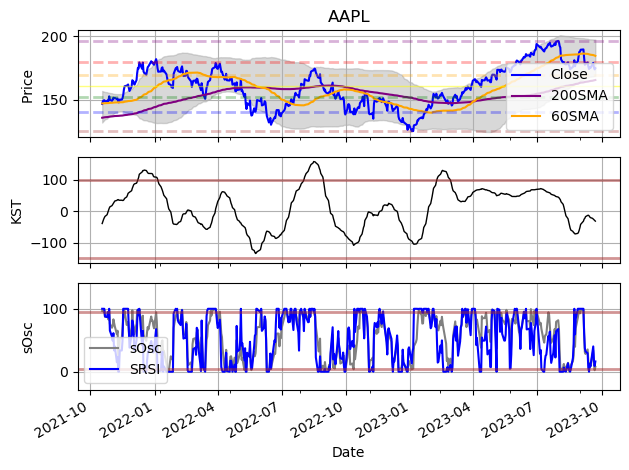

In [26]:
bb.plot_data()

In [27]:
bb.data.tail()

,Open,High,Low,Close,Adj Close,Volume,KST,TSI,pb90,Upper,Lower,200SMA,60SMA,sOsc,ROC,SRSI,buy_signal,sell_signal
Date,,,,,,,,,,,,,,,,,,
2023-09-18,176.479996,179.380005,176.169998,177.970001,177.970001,67257600,-22.411850,-12.081242,32.928567,197.601250,168.332084,164.92345,185.373000,26.946516,1.691336,31.927567,0.0,0.0
2023-09-19,177.520004,179.630005,177.130005,179.070007,179.070007,51826900,-24.365018,-11.011858,36.373120,197.550223,168.505556,165.07865,185.246167,33.637550,0.618085,40.158077,0.0,0.0
2023-09-20,179.259995,179.699997,175.399994,175.490005,175.490005,58436200,-26.773852,-11.762226,23.900021,197.524663,168.569783,165.21455,185.083167,11.861386,-1.999219,17.819572,0.0,0.0
2023-09-21,174.550003,176.300003,173.860001,173.929993,173.929993,63047900,-29.060265,-13.044976,18.370537,197.498780,168.625887,165.34515,184.847667,2.372259,-0.888947,9.018558,0.0,0.0
2023-09-22,174.669998,177.078995,174.054993,174.789993,174.789993,55110610,-31.281527,-13.576429,21.082159,197.447989,168.737123,165.48595,184.606667,7.603405,0.494452,16.243086,0.0,0.0


In [28]:
bb.run_cds_strategy()



running CDS strategy | KST, Bollinger Band 90, TSI
fixed costs 0.0proportional costs 0.0
('2022-05-19', 137.35000610351562) | buying 719 units at 139.02
2022-05-19| current balance 44.62
2022-05-19| current net wealth 98799.27
173.775
('2022-08-17', 174.5500030517578) | selling 719 units at 173.78
2022-08-17| current balance 124988.85
2022-08-17| current net wealth 124988.85
('2022-12-28', 126.04000091552734) | buying 984 units at 127.00
2022-12-28| current balance 20.85
2022-12-28| current net wealth 124044.21
158.75
('2023-03-21', 159.27999877929688) | selling 984 units at 158.75
2023-03-21| current balance 156230.85
2023-03-21| current net wealth 156230.85
2023-09-22 | inventory 0 units at 174.79
Final balance [$] 156230.85
Net performance [%] 56.23
Number of transaction executed [#] 5.00
